# Painting by prime number
Two weeks ago I stumbled upon the concept of [prime portraits](http://archive.bridgesmathart.org/2016/bridges2016-359.pdf). In short, prime portraits are pictures in which each color is assigned a number. When we align every pixel, the result should be a prime number. Because I could not find the code used in the article, I decided to recreate these prime portraits in Python - in color! Below is the Jupyter Notebook with the code I used to generate the Mona Lisa:

![mona lisa](http://www.pinchofintelligence.com/wp-content/uploads/2018/05/monalisa-prime.png)


## The concept
A prime portrait is a prime number formatted as a matrix with X digits per line. When we select a color for each digit, we can generate an image. 

Instead of doing this for many prime numbers and color schemes until you find something that resembles a known image, I have turned the process around. I have taken iconic images, such as the Mona Lisa and Starry Night, and converted them to images with only 10 colors. I assigned a digit to each color. Then I generated many similar images with a little bit of 'noise' added. The noise changed the colors in the images slightly, and thus the digits. If the digits in the image formed a prime number, I found a prime portrait!


![starry night](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/starrynight-prime-386kb.png)


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
from sklearn.cluster import KMeans
import scipy.misc
import PIL
from PIL import Image, ImageFont, ImageDraw

import numpy as np

from multiprocessing import Pool
import time
import random
import warnings

## Testing for primality
When working with extremely long primes, the naive method of testing each divisor will take way too much time. There are a lot of prime numbers and checking your number for each possible divisor takes too long to test a lot of prime portraits. 

Instead we take a probabilistic approach to the prime numbers. The [Miller Rabin](https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test) test uses heuristics to determine if a number is (probably) prime or not. I downloaded the [following code for the Miller-Rabin primality test from Rosetta code](https://rosettacode.org/wiki/Miller%E2%80%93Rabin_primality_test#Python:_Probably_correct_answers) to check for primality:

In [2]:
def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.

    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        
    return True # no base tested showed n as composite

assert is_probable_prime(2)
assert is_probable_prime(3)
assert not is_probable_prime(4)
assert  is_probable_prime(5)
assert not is_probable_prime(123456789)
primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
assert len(primes_under_1000) == 168
assert primes_under_1000[-10:] == [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
assert is_probable_prime(643808006803554439230129854961492699151386107534013432918073439524138264842370630061369715394739134090922937332590384720397133335969549256322620979036686633213903952966175107096769180017646161851573147596390153)
assert not is_probable_prime(743808006803554439230129854961492699151386107534013432918073439524138264842370630061369715394739134090922937332590384720397133335969549256322620979036686633213903952966175107096769180017646161851573147596390153)


## Generating the images
The basis of the algorithm is generating images with only 10 possible color values. I did not know what a common approach to this is, so I thought applying a [k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) would work. To do this, I reshaped an input image (so each pixel is a point in 3D space), clustered this, and used the 10 created clusters as color values. Sidenote: when your hammer is machine learning, everything looks like a nail...

Important for the prime generation is that you add a little bit of noise to the original image to create images that look the same, but are slightly different. This means that you created a different number, which is a new chance for us to find a prime number.

In [3]:
def get_k_means(image):
    pointcloud = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(pointcloud)
    return kmeans

def create_numbered_image(image, kmeans):
    """
    Turns an RGB image into an image with the labels of clusters of the supplied kmeans classifier. 
    """
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    """
    Turns an image with only values between 0 and 9 into a colored image by using the cluster centers 
    of the supplied kmeans classifier. 
    """
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image


### Numerised image examples
Here I create a few examples of small numerised images of the Mona Lisa. If you look closely you can see each image is slightly different, but you can still recognise the original picture. This is crucial for us, as this allows us to generate multiple numerised images that we can test for primality.

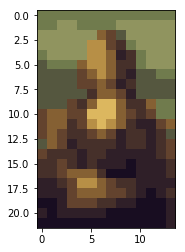

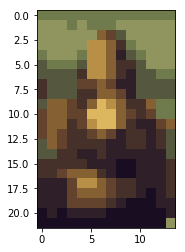

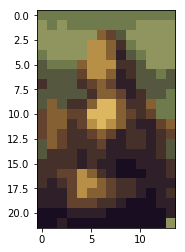

In [4]:
def load_and_resize_image(filename, resize_factor=18):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    
    oldshape = image.shape
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        resized_image = skimage.transform.resize(image, (oldshape[0]//resize_factor, oldshape[1]//resize_factor))

    return resized_image

resized_image = load_and_resize_image('input_pictures/monalisa.jpg')
kmeans = get_k_means(resized_image)
for _ in range(3):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

## Helper functions
I had to create some helper functions to return strings, integers, and load and show images.

In [5]:
def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    pimmage = Image.fromarray((image * 255).astype(np.uint8))
    resized_image = np.array(pimmage.resize((oldshape[1]*fontsize, oldshape[0]*fontsize), resample=PIL.Image.NEAREST))
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("pirulen rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

To verify if something is a good prime portrait I made the following helper functions: 

In [6]:
def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None
    
    
def print_result(string, n_image):
    print(string)
    print("-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))


## Multi threaded searching
At first I created a single-threaded solution, which worked. However, my laptop has multiple cores and could work on multiple numbers at the same time, so I rewrote my initial approach in a multi-threaded fashion: 

In [7]:
def print_result(string, n_image):
    print("Found a result: " + "-"*100)
    print(string)
    print("Represented as portrait:" + "-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))

def multi_threaded_prime_generator(resized_image, kmeans, filename, threads=4, log_process=True):
    image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(1000000))
    start = time.time() 
    with Pool(threads) as pool:
        results = pool.imap_unordered(is_good_prime_portrait, image_generator)
        total_results = 0
        
        for result in results:
            total_results += 1
            
            # Possibly log time spend searching this prime number
            if log_process and total_results%30==0:
                elapsed = time.time()
                elapsed = elapsed - start
                print("Seconds spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))

                
            if result != None: 
                # Found a prime number, print it and save it!
                integer, string, n_image = result
                print_result(string, n_image)
                normal_image = numbered_image_to_normal_image(n_image, kmeans)
                plt.imshow(normal_image)
                plt.show()
                show_and_save_image(normal_image, n_image, result_filename(filename))
                break
                
                
def search_prime_portrait(filename, resize_factor=16, log_process=True, threads=4):
    resized_image = load_and_resize_image(filename, resize_factor=resize_factor)
    print("Working with size " + str(resized_image.shape))
    kmeans = get_k_means(resized_image)
    multi_threaded_prime_generator(resized_image, kmeans, filename, log_process=log_process, threads=threads)



## Generating prime portraits
Now that we defined all functionality, it's finally time to generate the prime portraits! Play around with it and try to feed your own images. Note that you can pass the resize_factor variable to the function 'search prime portrait'. The bigger the resize_factor, the faster you can find a prime portrait. See below for more information on the exponential time it takes to generate larger prime portraits. 

Working with size (19, 13, 3)
Found a result: ----------------------------------------------------------------------------------------------------
9999999999999222299992222222222734922222222267402222999236781022200008778100994000433410000000048734409903388667840993334766784489838483704418883444841141408444141111140448441155551444837345115141113773844114111333841155415144115555515511555555551
Represented as portrait:----------------------------------------------------------------------------------------------------
9999999999999
2222999922222
2222273492222
2222267402222
9992367810222
0000877810099
4000433410000
0000487344099
0338866784099
3334766784489
8384837044188
8344484114140
8444141111140
4484411555514
4483734511514
1113773844114
1113338411554
1514411555551
5511555555551


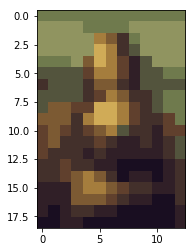

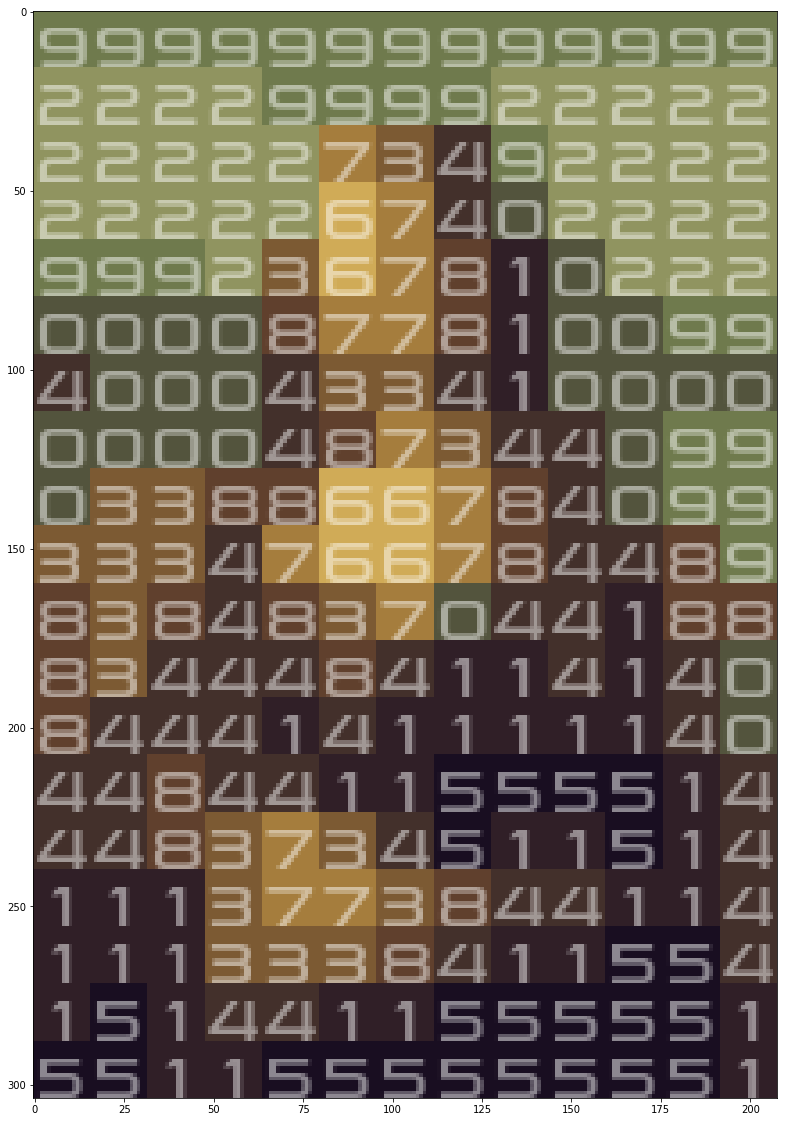

In [8]:
folder = 'input_pictures/'

filenames = [
    folder + 'monalisa.jpg',
    #folder + 'sunflowers.jpg',
    #folder + 'starrynight.jpg'
]
filename = filenames[0]

for filename in filenames:
    search_prime_portrait(filename, resize_factor=20, log_process=False, threads=4)


## How does this scale?
Apparently the [largest known prime number is 22338618 digits long](http://primes.utm.edu/largest.html). This would allow us to create a 4726 * 4726 prime portrait, which would be a prime portrait in 4K. I already enjoyed the big images of 'Starry Night', and I would absolutely love to have a 4K prime portrait of this painting. 

However: I noticed that finding prime numbers does not really scale. The length of the prime number grows quadratically with the resolution of your images, which causes big problems. Although the probability that you find a prime number only decreases linearly with the length of the prime number, it decreases quadratically when you get larger image resolutions. I plotted it in this image to show the effect up to 300x300:



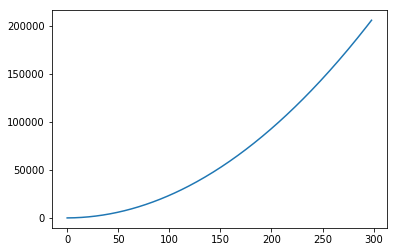

In [9]:
def trials_expected_img(w,h):
    return 2.3*w*h

needed = [trials_expected_img(x,x) for x in range(1,300)]
plt.plot(needed)

But what's even worse is that computing time grows quadratically with the length of the prime number. I also plotted this for my laptop up to an image resolution of 30x30:

Text(0, 0.5, 'Expected seconds')

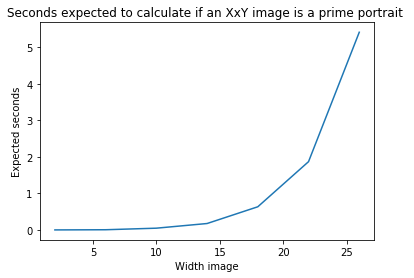

In [10]:
def time_expected_img(w,h):
    order = w*h
    start = time.time() 
    for _ in range(100):
        posprim = random.randrange(10**(order-1), 10**order)    
        a = is_probable_prime(posprim)
    end = time.time()
    return end - start

    
test_range = range(2,30,4)
time_needed = [time_expected_img(x,x) for x in test_range]
plt.plot(test_range, time_needed)
plt.title("Seconds expected to calculate if an XxY image is a prime portrait ")
plt.xlabel("Width image")
plt.ylabel("Expected seconds")

Combining both linear curves you can easily estimate the expected time you need to find a portrait of a certain size:

Text(0, 0.5, 'Expected seconds')

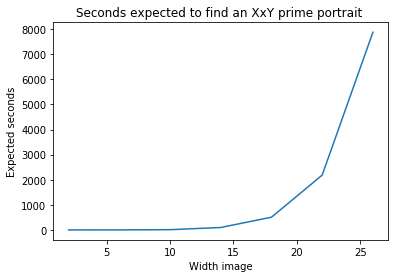

In [11]:
total_needed = [trials_expected_img(x,x)*time_expected_img(x,x) for x in test_range]
plt.plot(test_range, total_needed)
plt.title("Seconds expected to find an XxY prime portrait ")
plt.xlabel("Width image")
plt.ylabel("Expected seconds")

If you can find a more efficient Python implementation of a probabilistic prime checker, or implement it in a language more suitable to high demand computation, you can lower the time you need to generate these portraits. Each additional computer core also reduces this time a bit, but for now we can not expect 4K prime portraits anytime soon. 

## Conclusion and artworks
The last couple of weeks I really enjoyed letting my computer find prime portraits. Here are some of the artworks my computer found: 
![Sunflowers](http://www.pinchofintelligence.com/wp-content/uploads/2018/05/sunflowers-prime.png)
Sunflowers by Van Gogh
![Great wave](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/greatwave-prime-big.png)
Great wave by Hokusai
![Pearl](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/1200px-Girl_with_a_Pearl_Earring-prime.png)
Girl with a pearl earring by Vermeer

## Celebrity artworks
Although pictures of existing art often turn our pretty well, it is quite difficult to create good looking prime portraits of people. There is often not enough contrast in the resulting images, which uses only ten colors. I decided to try some portraits for people I like to follow online. Images that turned our well are: 

#### Ionica Smeets
Writes interesting articles in a Dutch newspaper every Saturday, and got featured a while ago in the Dutch comic called "Donald Duck": 
![Ionica Smeets](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/ionica_duck-prime.png)
#### Brady Haran
Makes interesting videos about mathematical concepts on the Numberphile Youtube channel. Also: has a cute dog ;)
![Brady Haran](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/brady-prime.png)
#### Roland Meertens
And myself.
![My face](http://www.pinchofintelligence.com/wp-content/uploads/2018/06/rolandface-prime.png)

## Requests
As I put the code online you can try to generate some prime portraits for yourself! If you really think I should try a certain artwork, feel free to reach out to me. Also: if you have a good idea what to do with these results, feel free to reach out. I know that I personally am going to hang the prime version of Starry Night on my wall!
